# M5 forcasting competition
* calendrier.csv : Contient des informations sur la date et les événements spéciaux.


* sell_prices.csv : Contient des informations sur les produits et leurs prix par magasin.


* sales_train_validation.csv : Contient des données historiques sur les ventes de produits ainsi que des détails sur le rayon, la catégorie, le magasin et l'état pour d_1-d_1913.


* sales_train_evaluation.csv : Contient des données historiques sur les ventes de produits ainsi que des détails sur le département, la catégorie, le magasin et l'état pour d_1-d_1941.



* Metric utiliser : RMSE
* objectif : prédire le nombre de vente par jour donné à l'aide de modèles

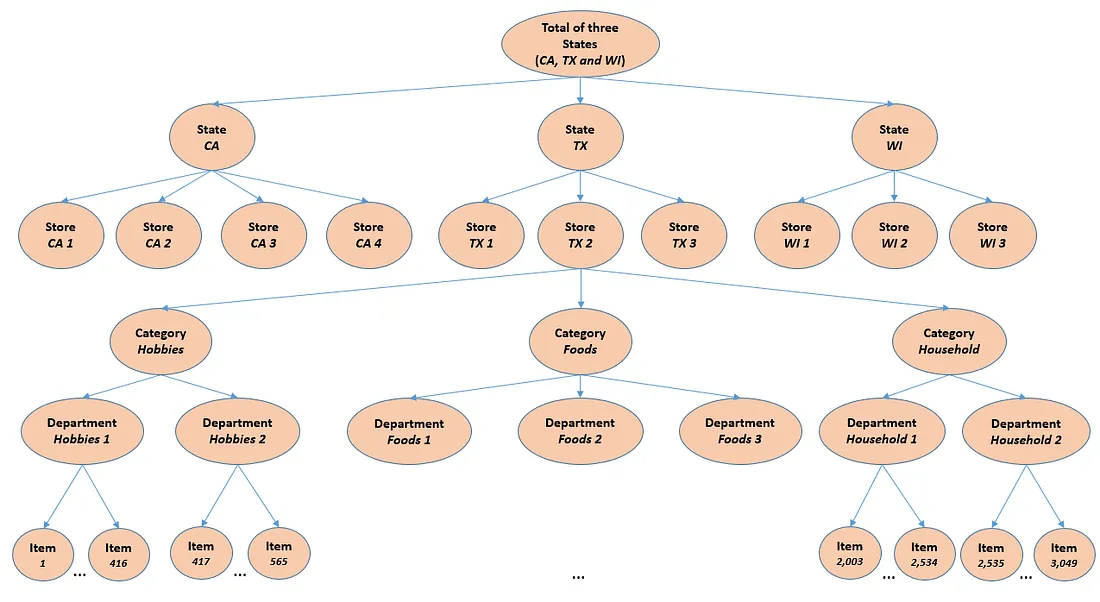

* Bibliotheque necessaire

In [ ]:
!pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=298cee8ad4e2c7552535fdedb9aa2e5817cdfdc738425fd9818b8b785213c60c
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 9.0 MB/s eta 0:00:00


In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#module pour la statistique :
import scipy.stats as stats
import statsmodels.stats.descriptivestats as smd
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA


#test de stationnarité
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import kpss

#ACF PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#module pour nos neurones
import tensorflow as tf
from tensorflow import keras

#RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU ,Dropout ,SimpleRNN

#module pour les module de regression classique
from sklearn.linear_model import LinearRegression

#module pour le traitement de nos donnés
from sklearn.preprocessing import StandardScaler

# metric de sklearn
from sklearn.metrics import  mean_squared_error, mean_absolute_error ,r2_score

tf.config.run_functions_eagerly(True) # pour activer la convertion de numpy en tenseur
#fixons la graine pour la reproduction des random
np.random.seed(42)


* chargement des données

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/fichier csv - excel/M5/"

In [ ]:
#Calendar data 101.04K
Calendar_data = pd.read_csv(path+'calendar.csv')

#Calendar data 193.97M
sell_prices_data = pd.read_csv(path+'sell_prices.csv')

#sales_train_evaluation data 116.1M
sales_train_evaluation_data = pd.read_csv(path+'sales_train_evaluation.csv')

#sales_train_validatioN data 114.45M
sales_train_validation_data = pd.read_csv(path+'sales_train_validation.csv')


* affichage des 1er ligne de chaque data

In [ ]:
print("calendar")
display(Calendar_data.head())


calendar


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
print("evaluation")
display(sales_train_evaluation_data.head())


evaluation


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [ ]:
print('sell prices')
display(sell_prices_data.head())


sell prices


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
print('validation')
display(sales_train_validation_data.head())


validation


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [ ]:
print("=="*10)
print(f"Calendar de shape {Calendar_data.shape} content: ",Calendar_data.columns.tolist())

print("=="*10)
print(f"sales_train_evaluation_data de shape{sales_train_evaluation_data.shape} content: ", sales_train_evaluation_data.columns.tolist())

print("=="*10)
print(f" sell_prices_data de shape {sell_prices_data.shape} content: " ,sell_prices_data.columns.tolist())

print("=="*10)
print(f"sales_train_validation_data de shape {sales_train_validation_data.shape} content: ", sales_train_validation_data.columns.tolist())

print("=="*10)



Calendar de shape (1969, 14) content:  ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI']
sales_train_evaluation_data de shape(30490, 1947) content:  ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10', 'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 'd_16', 'd_17', 'd_18', 'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26', 'd_27', 'd_28', 'd_29', 'd_30', 'd_31', 'd_32', 'd_33', 'd_34', 'd_35', 'd_36', 'd_37', 'd_38', 'd_39', 'd_40', 'd_41', 'd_42', 'd_43', 'd_44', 'd_45', 'd_46', 'd_47', 'd_48', 'd_49', 'd_50', 'd_51', 'd_52', 'd_53', 'd_54', 'd_55', 'd_56', 'd_57', 'd_58', 'd_59', 'd_60', 'd_61', 'd_62', 'd_63', 'd_64', 'd_65', 'd_66', 'd_67', 'd_68', 'd_69', 'd_70', 'd_71', 'd_72', 'd_73', 'd_74', 'd_75', 'd_76', 'd_77', 'd_78', 'd_79', 'd_80', 'd_81', 'd_82', 'd_83', 'd_84', 'd_85', 'd_86', 

`calendar_data` :

| Colonne       | Description |
|--------------|------------|
| **date** | Date complète au format YYYY-MM-DD. |
| **wm_yr_wk** | Identifiant de la semaine (Walmart year-week), utilisé pour relier les prix des produits (`sell_prices.csv`). |
| **weekday** | Jour de la semaine (Monday, Tuesday, ...). |
| **wday** | Code numérique du jour de la semaine (1 = samedi, 7 = vendredi). |
| **month** | Mois de l'année (1 à 12). |
| **year** | Année (2011, 2012, 2013, etc.). |
| **d** | Identifiant unique du jour (`d_1`, `d_2`, ..., `d_1941`), utilisé pour relier les ventes (`sales_train_evaluation.csv`). |
| **event_name_1** | Nom de l’événement (ex : Super Bowl, Christmas). |
| **event_type_1** | Type d’événement (National, Cultural, etc.). |
| **event_name_2** | Second événement, si applicable. |
| **event_type_2** | Type du second événement. |
| **snap_CA** | Indicateur de SNAP day (1 = jour où les bons alimentaires sont valables) pour la Californie. |
| **snap_TX** | Indicateur de SNAP day pour le Texas. |
| **snap_WI** | Indicateur de SNAP day pour le Wisconsin. |


---

`sales_train_evaluation_data` :

| Colonne       | Description |
|--------------|------------|
| **id** | Identifiant unique du produit (ex: `HOBBIES_1_001_CA_1_evaluation`). |
| **item_id** | Identifiant du produit sans l'information sur le magasin (ex: `HOBBIES_1_001`). |
| **dept_id** | Département du produit (`HOBBIES_1`, `FOODS_3`, etc.). |
| **cat_id** | Catégorie principale (`FOODS`, `HOUSEHOLD`, `HOBBIES`). |
| **store_id** | Identifiant du magasin (`CA_1`, `TX_2`, etc.). |
| **state_id** | État (`CA`, `TX`, `WI`). |
| **d_1 à d_1941** | Nombre d’unités vendues chaque jour (`d_1` = premier jour, `d_2` = deuxième jour, etc.). |


---

`sell_prices_data` :

| Colonne       | Description |
|--------------|------------|
| **store_id** | Identifiant du magasin (`CA_1`, `TX_2`, etc.). |
| **item_id** | Identifiant du produit (`HOBBIES_1_001`). |
| **wm_yr_wk** | Identifiant de la semaine Walmart (`1001`, `1002`, ...). |
| **sell_price** | Prix de vente du produit cette semaine dans ce magasin. |

---

* Colonne `item_id` commune a `sales_train_evaluation_data` et `sell_prices_data`

* Colonne `store_id` commune a `sales_train_evaluation_data` et `sell_prices_data`

* Colonne `wm_yr_wk` commune a `sales_train_evaluation_data` et `Calendar_data`

* sales_train_validation_data est pour la validation lors de l entrainement du model (il contient les meme ligne et col que sales_train_evaluation_data  excepter les 28 derniers jour )

---

* reorganistion de sales_train_evaluation_data  pour reduire le nombre de colonne : on fusionne les colonnes d en 2 colonne une qui represente  tout les jours  pour chaque enregistrement et une autre correspondant au nbre d unité vendu dans le jour


In [ ]:
sales_train_evaluation_melt_d_data = sales_train_evaluation_data.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                                              var_name="d", value_name="sales")



In [ ]:
sales_train_evaluation_melt_d_data.shape

(59181090, 8)

la fusion a ete bien  faite :

 le sales_train_evaluation_melt_d_data.shape == sales_train_evaluation_data.shape[0]*(sales_train_evaluation_data.shape[1] - 6)  == 59181090

fusion de `sales_train_evaluation_melt_d_data` et `calendar_`

In [ ]:
data = sales_train_evaluation_melt_d_data.merge(Calendar_data[['d','date','wm_yr_wk']],on = 'd',how = 'left')
data["date"] = pd.to_datetime(data["date"])



In [ ]:
data.columns.tolist()

['id',
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'd',
 'sales',
 'date',
 'wm_yr_wk']

agregation

In [ ]:
daily_sales = data.groupby('date')['sales'].sum().reset_index()


In [ ]:
daily_sales.columns.tolist()

['date', 'sales']

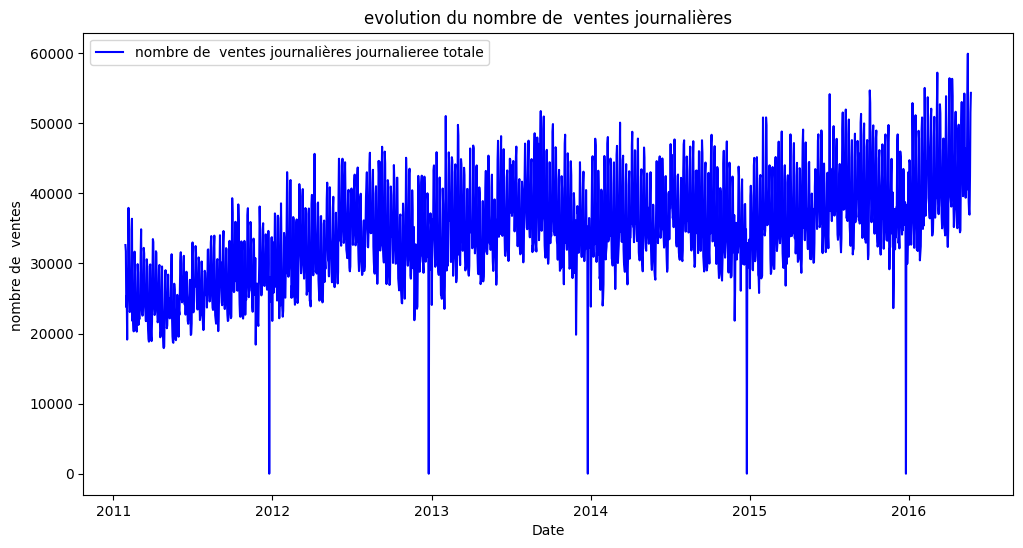

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['date'], daily_sales['sales'],label = "nombre de  ventes journalières journalieree totale",color= "b")
plt.xlabel('Date')
plt.ylabel('nombre de  ventes ')
plt.title('evolution du nombre de  ventes journalières')
plt.legend()
plt.show()

In [ ]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1941 non-null   datetime64[ns]
 1   sales   1941 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 30.5 KB


In [ ]:
daily_sales_missingvalues = daily_sales.isna().sum()
print(daily_sales_missingvalues)

date     0
sales    0
dtype: int64


decomposition de la serie

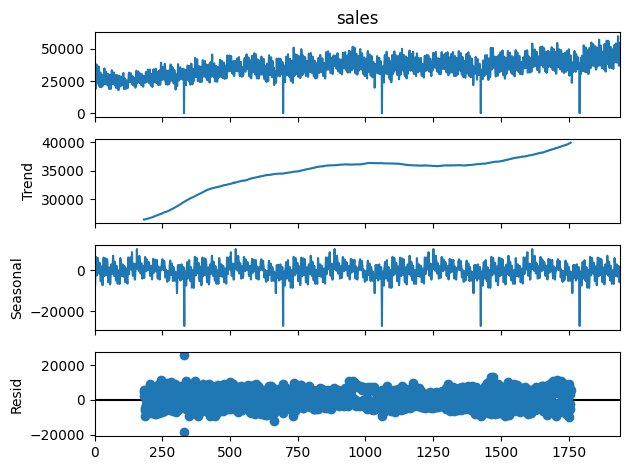

In [ ]:
result = seasonal_decompose(daily_sales["sales"], model="additive", period=365)   #period = 365  car d apres le plot precedant de la serie je suppose une tendance annuelle
result.plot()
plt.tight_layout()
plt.show()

TEST DE STATIONNARITE

In [ ]:
#ADF
result_adf = adfuller(daily_sales["sales"])
print("Test ADF:")
print(f"Statistic: {result_adf[0]:.4f}")
print(f"P-value: {result_adf[1]:.4f}")
if result_adf[1] <= 0.05:
    print("\nLa série est stationnaire (p-value ≤ 0.05).")
else:
    print("\nLa série n'est pas stationnaire (p-value > 0.05).")

Test ADF:
Statistic: -1.2961
P-value: 0.6310

La série n'est pas stationnaire (p-value > 0.05).


In [ ]:
#PP
result_pp = PhillipsPerron(daily_sales["sales"])
print(f"Test PP: p-value = {result_pp.pvalue:.4f}")

if result_pp.pvalue <= 0.05:
    print("La série est stationnaire car p-value ≤ 0.05 ")
else:
    print("La série n'est pas stationnaire car p-value > 0.05")


Test PP: p-value = 0.0000
La série est stationnaire car p-value ≤ 0.05 


In [ ]:
result_kpss = kpss(daily_sales["sales"])
print(f"Test KPSS: p-value = {result_kpss[1]:.4f}")

if result_kpss[1] > 0.05:
    print(" La série est stationnaire car p-value > 0.05 ")
else:
    print("La série n'est pas stationnaire car p-value ≤ 0.05")


Test KPSS: p-value = 0.0100
La série n'est pas stationnaire car p-value ≤ 0.05


<ipython-input-24-0f873dbbafc2>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(daily_sales["sales"])


Conclusion : Serie non stationnaire

differentiation de la serie

In [ ]:
ts_diff = daily_sales["sales"].diff().dropna()


teste de stationnarité de la serie differencier

In [ ]:
adf_diff_result = adfuller(ts_diff)
print("\nRésultat du test de stationnarité ADF :")
print(f"ADF Statistic : {adf_diff_result[0]}")
print(f"p-value : {adf_diff_result[1]}")
for key, value in adf_diff_result[4].items():
    print(f"Seuil critique {key} : {value}")

# Interprétation du test de stationnarité
if adf_diff_result[1] <= 0.05:
    print("\nLa série est stationnaire (p-value ≤ 0.05).")
else:
    print("\nLa série n'est pas stationnaire (p-value > 0.05).")


Résultat du test de stationnarité ADF :
ADF Statistic : -23.6383314278125
p-value : 0.0
Seuil critique 1% : -3.433772946369569
Seuil critique 5% : -2.8630520356606137
Seuil critique 10% : -2.567574949489954

La série est stationnaire (p-value ≤ 0.05).


In [ ]:
result_pp = PhillipsPerron(ts_diff)
print(f"Test PP: p-value = {result_pp.pvalue:.4f}")

if result_pp.pvalue <= 0.05:
    print("La série est stationnaire car p-value ≤ 0.05 ")
else:
    print("La série n'est pas stationnaire car p-value > 0.05")


Test PP: p-value = 0.0000
La série est stationnaire car p-value ≤ 0.05 


In [ ]:
result_kpss = kpss(ts_diff)
print(f"Test KPSS: p-value = {result_kpss[1]:.4f}")

if result_kpss[1] > 0.05:
    print(" La série est stationnaire car p-value > 0.05 ")
else:
    print("La série n'est pas stationnaire car p-value ≤ 0.05")


Test KPSS: p-value = 0.1000
 La série est stationnaire car p-value > 0.05 


<ipython-input-28-85b0f34c3195>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(ts_diff)


Conclusion : la serie est stationnaire d apres les 3 test
1 differentiatino suffi la serie devient stationnaire

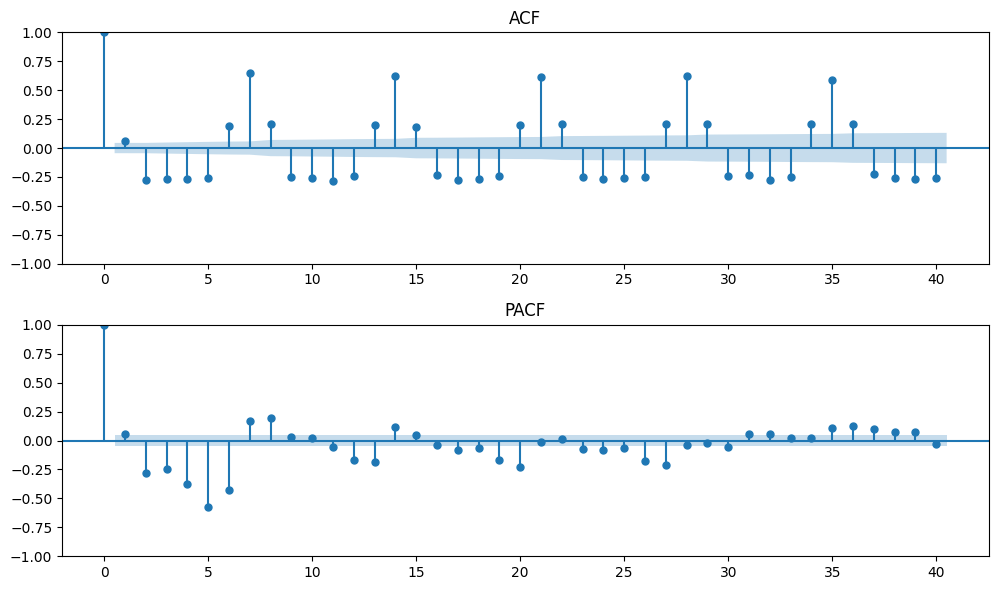

In [ ]:
plt.figure(figsize=(10, 6))

# ACF
plt.subplot(2, 1, 1)
plot_acf(ts_diff, lags=40, ax=plt.gca())
plt.title("ACF")

# PACF
plt.subplot(2, 1, 2)
plot_pacf(ts_diff, lags=40, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()


Analyse du graphe ACF et PACF :

ACF qui montre comment les valeurs de la série sont corrélées avec leurs propres valeurs passées.

PACF qui nous aide à identifier la dépendance directe entre une valeur et ses lags précédents.

Dans ACF :

Le premier pic est toujours à 1 .
ensuite  on voit plusieurs pics qui dépassent la zone bleue, mais ils diminuent petit à petit.Ça ressemble à un processus de type MA (moving average), donc on pourrait avoir un q

Dans PACF :

Il y a un peu pics importants au début, puis ça devient plus stable.==> les premiers lags sont significatifs et disparaissent vite, on voit la presence de AR (autoregressif), donc un p
p (ordre AR) non nul.

comme on a q et p non null on propose un model ARIMA(p,1,q) sur la Serie initial


model statistic

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=38101.482, Time=4.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39222.507, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39217.509, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39210.526, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39220.514, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=38408.694, Time=1.96 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=38025.731, Time=7.62 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=38358.429, Time=2.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=37443.889, Time=7.92 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=38152.722, Time=1.71 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=37335.242, Time=6.54 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=37705.893, Time=1.94 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=37323.445, Time=9.81 sec
 ARIMA(4,1,3)(0,0,0)[0] i

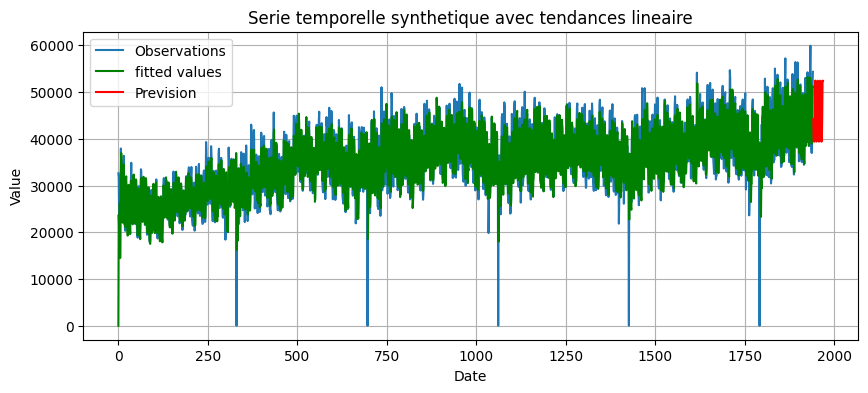

In [ ]:
import warnings # juste pour la beauté de l affichage
warnings.filterwarnings("ignore",category=FutureWarning)
import pmdarima as pm

# on rapelle tsdata
best_model = pm.auto_arima(daily_sales["sales"], seasonal=False ,trace=True,
                           error_action = 'ignore', suppress_warnings=True)
print(best_model.summary())

forecast = best_model.predict(n_periods=28) #period = 28 conformement au regle du concour M5
plt.figure(figsize=(10,4))
plt.plot(daily_sales["sales"], label='Observations')
plt.plot(best_model.predict_in_sample(), label='fitted values', color = 'green')
# Creating a range of values for the x-axis
x_axis_values = np.arange(len(daily_sales["sales"]), len(daily_sales["sales"]) + len(forecast))

# Plot forecast values
plt.plot(x_axis_values, forecast, label='Prevision', color='red')

plt.title('Serie temporelle synthetique avec tendances lineaire')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA
model_ARIMA_best = ARIMA(daily_sales["sales"], order=(4,1,5))
model_ARIMA_best_fit = model_ARIMA_best.fit()
print(model_ARIMA_best_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1941
Model:                 ARIMA(4, 1, 5)   Log Likelihood              -18536.774
Date:                Tue, 04 Mar 2025   AIC                          37093.547
Time:                        07:34:22   BIC                          37149.251
Sample:                             0   HQIC                         37114.032
                               - 1941                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8018      0.008     95.072      0.000       0.785       0.818
ar.L2         -1.4162      0.012   -121.365      0.000      -1.439      -1.393
ar.L3          0.7669      0.012     64.394      0.0

In [ ]:
# metric
residuals_best = model_ARIMA_best_fit.resid
MAE = np.mean(np.abs(residuals_best))
RMSE = np.sqrt(np.mean(residuals_best**2))
mape = np.mean(np.abs((residuals_best[1:] / daily_sales["sales"][1:]) * 100))
print("MAE:{:.4f}".format(MAE))
print("RMSE:{:.4f}".format(RMSE))
print("mape:{:.4f}".format(mape))





MAE:2251.9256
RMSE:3442.2119
mape:571.0362


OBSERVATION : les model statistique on   mal approcher la serie .
on obtient des metric assez elevé
en vois ainsi la limite les model statistique
cause problable :
Saisonnalité ignorée : La série semble avoir des motifs répétitifs annuels. mais on a utiliser un ARIMA  . on pourrait chercher le model Sarima qui colle plus

la chutes brusque dans le nombre de ventes
 a certains moment peut fausser les prévisions

essayon sarima

In [ ]:
import warnings # juste pour la beauté de l affichage
warnings.filterwarnings("ignore",category=FutureWarning)
import pmdarima as pm

# on rapelle tsdata
best_model = pm.auto_arima(daily_sales["sales"], seasonal=True,m=365 ,trace=True,
                           error_action = 'ignore', suppress_warnings=True)
print(best_model.summary())

forecast = best_model.predict(n_periods=28) #period = 28 conformement au regle du concour M5
plt.figure(figsize=(10,4))
plt.plot(daily_sales["sales"], label='Observations')
plt.plot(best_model.predict_in_sample(), label='fitted values', color = 'green')
# Creating a range of values for the x-axis
x_axis_values = np.arange(len(daily_sales["sales"]), len(daily_sales["sales"]) + len(forecast))

# Plot forecast values
plt.plot(x_axis_values, forecast, label='Prevision', color='red')

plt.title('Serie temporelle synthetique avec tendances lineaire')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

Performing stepwise search to minimize aic


le best model est donc un model SARIMA

In [ ]:
# metric
residuals_best = best_model.resid
MAE = np.mean(np.abs(residuals_best))
RMSE = np.sqrt(np.mean(residuals_best**2))
mape = np.mean(np.abs((residuals_best[1:] / daily_sales["sales"][1:]) * 100))
print("MAE:{:.4f}".format(MAE))
print("RMSE:{:.4f}".format(RMSE))
print("mape:{:.4f}".format(mape))





passons au model deep learning

In [ ]:
def plot_series(time , series , format = "-",start = 0 , end = None , label = None,title = None ):
  """
  definition de notre fonction pour le plot de la time serie :
    time = interalle ed temps
    series =  les valeur de la serie
    start , end = plage d indices de temps a tracer
    label  = eqiuette  pour notre legende
  """
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.title(title)
  plt.grid(True)
  if label:
        plt.legend()


* traitement des données

In [ ]:
Serie =  np.array(ts_diff)

In [ ]:
Scaler_Serie = StandardScaler()
Serie = Serie.reshape(-1,1)
Scaler_Serie.fit(Serie)
Serie_scaled = Scaler_Serie.transform(Serie)


In [ ]:
time = range(0,len(Serie))

In [ ]:
# np.array(daily_sales["date"])

* * fonction de fenetrage

In [ ]:
def window(serie , w , step =1):
  #X constitue les features
  #y = les label
  X=[]
  y = []
  for i in range(0,len(serie)-w,step):
      k = i+w
      X.append(serie[i:k])
      y.append(serie[k])

  X=np.array(X)
  X=X.reshape(X.shape[0], X.shape[1])
  y=np.array(y)
  y=y.flatten()
  return X , y



split

In [ ]:
w=1
X_windowed , Y_windowed = window(Serie_scaled , 5 , step =1)
test_size = 0.3
train_size = int(len(X_windowed)*(1-test_size))
X_train= X_windowed[:train_size]
X_test = X_windowed[train_size:]
y_train= Y_windowed[:train_size]
y_test= Y_windowed[train_size:]



ANN

In [ ]:
model1 = keras.Sequential([
    keras.layers.Dense(units= 64 ,activation =None ,input_shape =[X_train.shape[1]]  ),
    keras.layers.Dense(units=1 ,activation ="linear"  ),
])

Adam=keras.optimizers.Adam(learning_rate=0.04)
model1.compile(optimizer=Adam , loss='mean_squared_error',metrics=['mae'])
history1 = model1.fit(X_train,y_train,epochs=10 , verbose=1, batch_size=100)
y_predict_ner=model1.predict(X_test)

model1.summary()



In [ ]:
plt.figure(figsize=(15,8))
plot_series(time[0:int(len(Serie)*(1-0.3))] , Serie_scaled[0:int(len(Serie)*(1-0.3))] , format = "-",start = 0 , end = None ,label = 'Time serie original' ,title = "Time serie" )
plot_series(time[int(len(Serie)*(1-0.3))+2: ] , y_predict_ner[:len(time[int(len(Serie)*(1-0.3))+2: ]),0],start = 0 , end = None , format = "-", label = 'Time serie predit' ,title = "Time serie" )

# évaluatino du model
print('sklearn neurone Regression')
MSE_ner = mean_squared_error(y_test , y_predict_ner)
MAE_ner = mean_absolute_error(y_test , y_predict_ner)
R2_ner = r2_score(y_test , y_predict_ner)
print('MSE : ',MSE_ner)
print('MAE : ',MAE_ner)
print('R² : ',R2_ner)

RNN

In [ ]:
X_trai  = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_tes = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)



In [ ]:
regressor = keras.Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_trai.shape[1],X_trai.shape[2])))
regressor.add(Dropout(0.2))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(keras.layers.Dense(units = 1,activation='linear'))
Adam=keras.optimizers.Adam(learning_rate=0.04)
# compiling RNN
history_RNN=regressor.compile(optimizer = Adam,
                  loss = "mean_squared_error",
                  metrics=['mae'])

# fitting the model
regressor.fit(X_trai, y_train, epochs = 10, batch_size = 100)
y_predict_RNN=regressor.predict(X_test)

regressor.summary()


In [ ]:
plt.figure(figsize=(15,8))
plot_series(time[0:int(len(Serie)*(1-0.3))] , Serie_scaled[0:int(len(Serie)*(1-0.3))] , format = "-",start = 0 , end = None ,label = 'Time serie original' ,title = "Time serie" )
plot_series(time[int(len(Serie)*(1-0.3))+2: ] , y_predict_RNN[:len(time[int(len(Serie)*(1-0.3))+2: ]),0],start = 0 , end = None , format = "-", label = 'Time serie predit' ,title = "Time serie" )
# évaluation du model
print('RNN')
MSE_RNN = mean_squared_error(y_test , y_predict_RNN)
MAE_RNN = mean_absolute_error(y_test , y_predict_RNN)
R2_RNN = r2_score(y_test , y_predict_RNN)
print('MSE : ',MSE_RNN)
print('MAE : ',MAE_RNN)
print('R² : ',R2_RNN)

LSTM

In [ ]:
model_LSTM = keras.Sequential([
  LSTM(units=64, activation='tanh',return_sequences = True,input_shape=(X_trai.shape[1],X_trai.shape[2]) ),
    keras.layers.Dense(units=1 ,activation ="linear"  ),
  LSTM(units=64, activation='tanh',return_sequences = False) ,
    keras.layers.Dense(units=1 ,activation ="linear"  ),

])

Adam=keras.optimizers.Adam(learning_rate=0.04)
model_LSTM.compile(optimizer=Adam , loss='mean_squared_error',metrics=['mae'])
history_LSTM = model_LSTM.fit(X_trai,y_train,epochs=10 , verbose=1, batch_size=100)
y_predict_LSTM=model_LSTM.predict(X_tes)

model_LSTM.summary()



In [ ]:
plt.figure(figsize=(15,8))
plot_series(time[0:int(len(Serie)*(1-0.3))] , Serie_scaled[0:int(len(Serie)*(1-0.3))] , format = "-",start = 0 , end = None ,label = 'Time serie original' ,title = "Time serie" )
plot_series(time[int(len(Serie)*(1-0.3))+2: ] , y_predict_LSTM[:len(time[int(len(Serie)*(1-0.3))+2: ]),0],start = 0 , end = None , format = "-", label = 'Time serie predit' ,title = "Time serie" )

# évaluation du model
print('LSTM')
MSE_LSTM = mean_squared_error(y_test , y_predict_LSTM)
MAE_LSTM = mean_absolute_error(y_test , y_predict_LSTM)
R2_LSTM = r2_score(y_test , y_predict_LSTM)
print('MSE : ',MSE_LSTM)
print('MAE : ',MAE_LSTM)
print('R² : ',R2_LSTM)

GRU

In [ ]:
model_GRU = keras.Sequential([
    GRU( units=64, activation='tanh', return_sequences=True, input_shape=(X_trai.shape[1],X_trai.shape[2])),
    Dropout(0.2),
    GRU(32, activation='tanh'),
    keras.layers.Dense(1, activation='linear')
])

Adam=keras.optimizers.Adam(learning_rate=0.04)
model_GRU.compile(optimizer=Adam , loss='mean_squared_error',metrics=['mae'])
history_GRU = model_GRU.fit(X_trai,y_train,epochs=10 , verbose=1, batch_size=100)
y_predict_GRU=model_GRU.predict(X_tes)

model_LSTM.summary()


In [ ]:
plt.figure(figsize=(15,8))
plot_series(time[0:int(len(Serie)*(1-0.3))] , Serie_scaled[0:int(len(Serie)*(1-0.3))] , format = "-",start = 0 , end = None ,label = 'Time serie original' ,title = "Time serie" )
plot_series(time[int(len(Serie)*(1-0.3))+2: ] , y_predict_GRU[:len(time[int(len(Serie)*(1-0.3))+2: ]),0],start = 0 , end = None , format = "-", label = 'Time serie predit' ,title = "Time serie" )

# évaluatino du model
print('gru')
MSE_GRU = mean_squared_error(y_test , y_predict_GRU)
MAE_GRU = mean_absolute_error(y_test , y_predict_GRU)
R2_GRU = r2_score(y_test , y_predict_GRU)
print('MSE : ',MSE_GRU)
print('MAE : ',MAE_GRU)
print('R² : ',R2_GRU)

le resulta du GRU est acceptable avect une MSE minimiser mais n ayant pas realiser de gros model profon on ne serait generalement conclure mais au vue des resultat abtenu le model GRU a donner de meilleur resultat . mais en globalité on a obtenu de meilleur resultat avec les medel de deep learning que les model statique qui non on donnée des mesure de performande élevé .

indication :  les code de deep learning son iinspirer du site source : https://www.geeksforgeeks.org

# essayon de de predire le benefice total journalier de walmart maintenant :

In [ ]:
data = data.merge(sell_prices_data[['store_id', 'item_id', 'wm_yr_wk', 'sell_price']],on = ['store_id', 'item_id', 'wm_yr_wk'],how = 'left')
data["profit_produit"] = data["sell_price"]*data["sales"]

daily_profit = data.groupby('date')['profit_produit'].sum().reset_index()



In [ ]:
daily_profit.columns.tolist()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(daily_profit['date'], daily_profit['profit_produit'],label = " profit journalières journalieree totale",color= "b")
plt.xlabel('Date')
plt.ylabel('profit ')
plt.title('evolution du profit journalières de la firme')
plt.legend()
plt.show()

In [ ]:
daily_profit.info()

In [ ]:
daily_profit_missingvalues = daily_profit.isna().sum()
print(daily_profit_missingvalues)

In [ ]:
result = seasonal_decompose(daily_profit["profit_produit"], model="additive", period=365)   #period = 365  car d apres le plot precedant de la serie je suppose une tendance annuelle
result.plot()
plt.tight_layout()
plt.show()

In [ ]:
#ADF
result_adf = adfuller(daily_profit["profit_produit"])
print("Test ADF:")
print(f"Statistic: {result_adf[0]:.4f}")
print(f"P-value: {result_adf[1]:.4f}")
if result_adf[1] <= 0.05:
    print("\nLa série est stationnaire (p-value ≤ 0.05).")
else:
    print("\nLa série n'est pas stationnaire (p-value > 0.05).")

In [ ]:
#PP
result_pp = PhillipsPerron(daily_profit["profit_produit"])
print(f"Test PP: p-value = {result_pp.pvalue:.4f}")

if result_pp.pvalue <= 0.05:
    print("La série est stationnaire car p-value ≤ 0.05 ")
else:
    print("La série n'est pas stationnaire car p-value > 0.05")


In [ ]:
result_kpss = kpss(daily_profit["profit_produit"])
print(f"Test KPSS: p-value = {result_kpss[1]:.4f}")

if result_kpss[1] > 0.05:
    print(" La série est stationnaire car p-value > 0.05 ")
else:
    print("La série n'est pas stationnaire car p-value ≤ 0.05")


In [ ]:
#si serie non stationnaire
ts_diff = daily_profit["profit_produit"].diff().dropna()


In [ ]:
plt.figure(figsize=(10, 6))

# ACF
plt.subplot(2, 1, 1)
plot_acf(ts_diff, lags=40, ax=plt.gca())
plt.title("ACF")

# PACF
plt.subplot(2, 1, 2)
plot_pacf(ts_diff, lags=40, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()


In [ ]:
import warnings # juste pour la beauté de l affichage
warnings.filterwarnings("ignore",category=FutureWarning)
import pmdarima as pm

# on rapelle tsdata
best_model = pm.auto_arima(daily_profit["profit_produit"], seasonal=False ,trace=True,
                           error_action = 'ignore', suppress_warnings=True)
print(best_model.summary())

forecast = best_model.predict(n_periods=28) #period = 28 conformement au regle du concour M5
plt.figure(figsize=(10,4))
plt.plot(daily_profit["profit_produit"], label='Observations')
plt.plot(best_model.predict_in_sample(), label='fitted values', color = 'green')
# Creating a range of values for the x-axis
x_axis_values = np.arange(len(daily_profit["profit_produit"]), len(daily_profit["profit_produit"]) + len(forecast))

# Plot forecast values
plt.plot(x_axis_values, forecast, label='Prevision', color='red')

plt.title('Serie temporelle synthetique avec tendances lineaire')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA
# model_ARIMA_best = ARIMA(daily_sales["sales"], order=(4,1,5))
model_ARIMA_best_fit = model_ARIMA_best.fit()
print(model_ARIMA_best_fit.summary())

In [ ]:
# metric
residuals_best = model_ARIMA_best_fit.resid
MAE = np.mean(np.abs(residuals_best))
RMSE = np.sqrt(np.mean(residuals_best**2))
mape = np.mean(np.abs((residuals_best[1:] / daily_profit["profit_produit"][1:]) * 100))
print("MAE:{:.4f}".format(MAE))
print("RMSE:{:.4f}".format(RMSE))
print("mape:{:.4f}".format(mape))





In [ ]:
Serie =  np.array(ts_diff)

In [ ]:
Scaler_Serie = StandardScaler()
Serie = Serie.reshape(-1,1)
Scaler_Serie.fit(Serie)
Serie_scaled = Scaler_Serie.transform(Serie)


In [ ]:
time = range(0,len(Serie))

In [ ]:
w=1
X_windowed , Y_windowed = window(Serie_scaled , 5 , step =1)
test_size = 0.3
train_size = int(len(X_windowed)*(1-test_size))
X_train= X_windowed[:train_size]
X_test = X_windowed[train_size:]
y_train= Y_windowed[:train_size]
y_test= Y_windowed[train_size:]



In [ ]:
model1 = keras.Sequential([
    keras.layers.Dense(units= 64 ,activation =None ,input_shape =[X_train.shape[1]]  ),
    keras.layers.Dense(units=1 ,activation ="linear"  ),
])

Adam=keras.optimizers.Adam(learning_rate=0.04)
model1.compile(optimizer=Adam , loss='mean_squared_error',metrics=['mae'])
history1 = model1.fit(X_train,y_train,epochs=10 , verbose=1, batch_size=100)
y_predict_ner=model1.predict(X_test)

model1.summary()



In [ ]:
plt.figure(figsize=(15,8))
plot_series(time[0:int(len(Serie)*(1-0.3))] , Serie_scaled[0:int(len(Serie)*(1-0.3))] , format = "-",start = 0 , end = None ,label = 'Time serie original' ,title = "Time serie" )
plot_series(time[int(len(Serie)*(1-0.3))+2: ] , y_predict_ner[:len(time[int(len(Serie)*(1-0.3))+2: ]),0],start = 0 , end = None , format = "-", label = 'Time serie predit' ,title = "Time serie" )

# évaluatino du model
print('sklearn neurone Regression')
MSE_ner = mean_squared_error(y_test , y_predict_ner)
MAE_ner = mean_absolute_error(y_test , y_predict_ner)
R2_ner = r2_score(y_test , y_predict_ner)
print('MSE : ',MSE_ner)
print('MAE : ',MAE_ner)
print('R² : ',R2_ner)


In [ ]:
X_trai  = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_tes = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)



In [ ]:
regressor = keras.Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_trai.shape[1],X_trai.shape[2])))
regressor.add(Dropout(0.2))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(keras.layers.Dense(units = 1,activation='linear'))
Adam=keras.optimizers.Adam(learning_rate=0.04)
# compiling RNN
history_RNN=regressor.compile(optimizer = Adam,
                  loss = "mean_squared_error",
                  metrics=['mae'])

# fitting the model
regressor.fit(X_trai, y_train, epochs = 10, batch_size = 100)
y_predict_RNN=regressor.predict(X_test)

regressor.summary()


In [ ]:
plt.figure(figsize=(15,8))
plot_series(time[0:int(len(Serie)*(1-0.3))] , Serie_scaled[0:int(len(Serie)*(1-0.3))] , format = "-",start = 0 , end = None ,label = 'Time serie original' ,title = "Time serie" )
plot_series(time[int(len(Serie)*(1-0.3))+2: ] , y_predict_RNN[:len(time[int(len(Serie)*(1-0.3))+2: ]),0],start = 0 , end = None , format = "-", label = 'Time serie predit' ,title = "Time serie" )
# évaluation du model
print('RNN')
MSE_RNN = mean_squared_error(y_test , y_predict_RNN)
MAE_RNN = mean_absolute_error(y_test , y_predict_RNN)
R2_RNN = r2_score(y_test , y_predict_RNN)
print('MSE : ',MSE_RNN)
print('MAE : ',MAE_RNN)
print('R² : ',R2_RNN)

In [ ]:
model_LSTM = keras.Sequential([
  LSTM(units=64, activation='tanh',return_sequences = True,input_shape=(X_trai.shape[1],X_trai.shape[2]) ),
    keras.layers.Dense(units=1 ,activation ="linear"  ),
  LSTM(units=64, activation='tanh',return_sequences = False) ,
    keras.layers.Dense(units=1 ,activation ="linear"  ),

])

Adam=keras.optimizers.Adam(learning_rate=0.04)
model_LSTM.compile(optimizer=Adam , loss='mean_squared_error',metrics=['mae'])
history_LSTM = model_LSTM.fit(X_trai,y_train,epochs=10 , verbose=1, batch_size=100)
y_predict_LSTM=model_LSTM.predict(X_tes)

model_LSTM.summary()



In [ ]:
plt.figure(figsize=(15,8))
plot_series(time[0:int(len(Serie)*(1-0.3))] , Serie_scaled[0:int(len(Serie)*(1-0.3))] , format = "-",start = 0 , end = None ,label = 'Time serie original' ,title = "Time serie" )
plot_series(time[int(len(Serie)*(1-0.3))+2: ] , y_predict_LSTM[:len(time[int(len(Serie)*(1-0.3))+2: ]),0],start = 0 , end = None , format = "-", label = 'Time serie predit' ,title = "Time serie" )

# évaluation du model
print('LSTM')
MSE_LSTM = mean_squared_error(y_test , y_predict_LSTM)
MAE_LSTM = mean_absolute_error(y_test , y_predict_LSTM)
R2_LSTM = r2_score(y_test , y_predict_LSTM)
print('MSE : ',MSE_LSTM)
print('MAE : ',MAE_LSTM)
print('R² : ',R2_LSTM)

In [ ]:
model_GRU = keras.Sequential([
    GRU( units=64, activation='tanh', return_sequences=True, input_shape=(X_trai.shape[1],X_trai.shape[2])),
    Dropout(0.2),
    GRU(32, activation='tanh'),
    keras.layers.Dense(1, activation='linear')
])

Adam=keras.optimizers.Adam(learning_rate=0.04)
model_GRU.compile(optimizer=Adam , loss='mean_squared_error',metrics=['mae'])
history_GRU = model_GRU.fit(X_trai,y_train,epochs=10 , verbose=1, batch_size=100)
y_predict_GRU=model_GRU.predict(X_tes)

model_LSTM.summary()


In [ ]:
plt.figure(figsize=(15,8))
plot_series(time[0:int(len(Serie)*(1-0.3))] , Serie_scaled[0:int(len(Serie)*(1-0.3))] , format = "-",start = 0 , end = None ,label = 'Time serie original' ,title = "Time serie" )
plot_series(time[int(len(Serie)*(1-0.3))+2: ] , y_predict_GRU[:len(time[int(len(Serie)*(1-0.3))+2: ]),0],start = 0 , end = None , format = "-", label = 'Time serie predit' ,title = "Time serie" )

# évaluatino du model
print('gru')
MSE_GRU = mean_squared_error(y_test , y_predict_GRU)
MAE_GRU = mean_absolute_error(y_test , y_predict_GRU)
R2_GRU = r2_score(y_test , y_predict_GRU)
print('MSE : ',MSE_GRU)
print('MAE : ',MAE_GRU)
print('R² : ',R2_GRU)